# Training notebook for Audioset classification using attention

In [1]:
# print multiple lines per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import time
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam


### basic model params setup

In [4]:
num_time_steps = 10  # vggish
emb_size = 128  # vggish
num_labels = 527  # audioset

hidden_layer_sizes = [1024, 1024, 1024]
dropout_rate = 0.5

in_out_sizes = list(zip([emb_size] + hidden_layer_sizes[:-1], hidden_layer_sizes))
in_out_sizes

[(128, 1024), (1024, 1024), (1024, 1024)]

### Single attention layer

In [5]:
def attn_layers(layer_size=hidden_layer_sizes[-1]):
    def attn_pool(inputs):
#         inputs = layers.Input(shape = input_shape)
        feats = layers.Dense(layer_size, activation='linear')(inputs)
        attentions = layers.Dense(layer_size, activation='sigmoid')(inputs)
        attentions = layers.Lambda(lambda x: K.clip(x, 1e-9, 1-1e-9))(attentions)
        attentions = attentions / K.sum(attentions, axis=1, keepdims=True)

        outputs = K.sum(feats * attentions, axis = 1)
        return outputs
    
    return [layers.Lambda(attn_pool)]
    

### Initial layers including casting int8 to float

In [6]:
transform_layers = [layers.Lambda(lambda x: K.cast(x, 'float32')/128. - 1., input_shape=(num_time_steps, emb_size))]

linear_layers = []
for i,o in in_out_sizes:
    linear_layers += [
        layers.Dense(o, input_shape=(num_time_steps, i)),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(rate=dropout_rate),
    ]

### Final layers after attention

In [7]:
final_layers = [
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dense(num_labels, activation='sigmoid'),
]

### Model Definition

In [8]:
model = Sequential(transform_layers + linear_layers + attn_layers(1024) + final_layers)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 10, 128)           0         
_________________________________________________________________
dense (Dense)                (None, 10, 1024)          132096    
_________________________________________________________________
batch_normalization_v1 (Batc (None, 10, 1024)          4096      
_________________________________________________________________
activation (Activation)      (None, 10, 1024)          0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 1024)          0         
_________________________________________________________________
dense_1 (Dense)      

### Load both bal and unbal data since batches are already balanced
bal is about 1% of unbal data though

In [12]:
import h5py

bal_fname = 'packed_features/bal_train.h5'
unbal_fname = 'packed_features/unbal_train.h5'
eval_fname = 'packed_features/eval.h5'

with h5py.File(bal_fname, 'r') as bal_data, h5py.File(unbal_fname, 'r') as unbal_data:
    train_bal_x = bal_data['x'][:]
    train_bal_y = bal_data['y'][:]
    train_x = np.concatenate([train_bal_x, unbal_data['x'][:]])
    train_y = np.concatenate([train_bal_y, unbal_data['y'][:]])

with h5py.File(eval_fname, 'r') as eval_data:
    test_x = eval_data['x'][:]
    test_y = eval_data['y'][:]
    
train_x.shape
train_y.shape
test_x.shape
test_y.shape

(2063949, 10, 128)

(2063949, 527)

(20371, 10, 128)

(20371, 527)

### Generator for balanced mini-batches

In [13]:
class BalGen(object):
    """Generator for mini batches with balanced number of classes. 
    """
    
    def __init__(self, x, y, batch_size, shuffle=True, seed=42, verbose=0):
        """
        Args:
          x: ndarray
          y: 2D array
          batch_size: int
          shuffle: bool
          seed: int
          verbose: int
        """
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.rs = np.random.RandomState(seed)
        self.verbose = verbose
        
        assert self.y.ndim == 2, "y must have dimension of 2!"
            
    def get_classes_set(self, samples_num_of_classes):
        
        classes_num = len(samples_num_of_classes)
        classes_set = []
        
        for k in range(classes_num):
            classes_set += [k]
            
        return classes_set
        
    def generate(self, max_iteration=None):
        
        y = self.y
        batch_size = self.batch_size

        (samples_num, classes_num) = y.shape
        
        samples_num_of_classes = np.sum(y, axis=0)
        
        # E.g. [0, 1, 1, 2, ..., K, K]
        classes_set = self.get_classes_set(samples_num_of_classes)
        
        if self.verbose:
            print("samples_num_of_classes: {}".format(samples_num_of_classes))
            print("classes_set: {}".format(classes_set))
        
        # E.g. [[0, 1, 2], [3, 4, 5, 6], [7, 8], ...]
        indexes_of_classes = []
        
        for k in range(classes_num):
            indexes_of_classes.append(np.where(y[:, k] == 1)[0])
            
        # Shuffle indexes
        if self.shuffle:
            for k in range(classes_num):
                self.rs.shuffle(indexes_of_classes[k])
        
        queue = []
        iteration = 0
        pointers_of_classes = [0] * classes_num

        while True:
            
            if iteration == max_iteration:
                break
            
            # Get a batch containing classes from a queue
            while len(queue) < batch_size:
                self.rs.shuffle(classes_set)
                queue += classes_set
                
            batch_classes = queue[0 : batch_size]
            queue[0 : batch_size] = []
            
            samples_num_of_classes_in_batch = [batch_classes.count(k) for k in range(classes_num)]
            batch_idxes = []
            
            # Get index of data from each class
            for k in range(classes_num):
                
                bgn_pointer = pointers_of_classes[k]
                fin_pointer = pointers_of_classes[k] + samples_num_of_classes_in_batch[k]
                
                per_class_batch_idxes = indexes_of_classes[k][bgn_pointer : fin_pointer]
                batch_idxes.append(per_class_batch_idxes)

                pointers_of_classes[k] += samples_num_of_classes_in_batch[k]
                
                if pointers_of_classes[k] >= samples_num_of_classes[k]:
                    pointers_of_classes[k] = 0
                    
                    if self.shuffle:
                        self.rs.shuffle(indexes_of_classes[k])
                
            batch_idxes = np.concatenate(batch_idxes, axis=0)
            
            iteration += 1
            
            yield self.x[batch_idxes], self.y[batch_idxes]

In [14]:
# gen = BalGen(x, y, batch_size=256, shuffle=True, seed=42, verbose=0)

In [15]:
# for (batch_x, batch_y) in gen.generate(max_iteration=2):
#     print(batch_y.sum(axis=0))
# #     print(batch_x.shape)

### helper functions for metrics

In [16]:
from scipy.stats import norm
from sklearn.metrics import average_precision_score, roc_auc_score, roc_curve, precision_recall_curve

def calc_d_prime(auc):
    standard_normal = norm()
    d_prime = standard_normal.ppf(auc) * np.sqrt(2.0)
    return d_prime

def calc_metrics(output, target):
    """Calculate all the metrics, eg. mAP, AUC etc.

    Args:
      output: 2d array, (samples_num, classes_num)
      target: 2d array, (samples_num, classes_num)

    Returns:
      stats: list of statistic of each class.
    """

    classes_num = target.shape[-1]
    metrics = []

    # Class-wise statistics
    for k in range(classes_num):

        # Average precision
        avg_precision = average_precision_score(
            target[:, k], output[:, k], average=None)

        # AUC
        auc = roc_auc_score(target[:, k], output[:, k], average=None)

        # Precisions, recalls
        (precisions, recalls, thresholds) = precision_recall_curve(
            target[:, k], output[:, k])

        # FPR, TPR
        (fpr, tpr, thresholds) = roc_curve(target[:, k], output[:, k])

        save_every_steps = 1000     # Sample statistics to reduce size
        dict = {'precisions': precisions[0::save_every_steps],
                'recalls': recalls[0::save_every_steps],
                'AP': avg_precision,
                'fpr': fpr[0::save_every_steps],
                'fnr': 1. - tpr[0::save_every_steps],
                'auc': auc,
               }
        metrics.append(dict)

    return metrics

def evaluate(model, x, target):
    """Evaluate a model on x vs target.

    Args:
      model: Keras model
      x: 2d array, (samples_num, classes_num)
      target: 2d array, (samples_num, classes_num)
    Returns:
      None
    """

#     callback_time = time.time()
    (clips_num, time_steps, freq_bins) = x.shape
    output = model.predict(x)

    # Calculate statistics
    metrics = calc_metrics(output, target)

    mAP = np.mean([m['AP'] for m in metrics])
    mAUC = np.mean([m['auc'] for m in metrics])
    d_prime = calc_d_prime(mAUC)
    
    return {
        'mAP': mAP, 'mAUC':mAUC, 'd_prime': d_prime,
#         'mPrecisions':mPrecisions, 'mRecalls':mRecalls, 'mFpr':mFpr, 'mFnr':mFnr,
    }


## Training setups

In [20]:
batch_size = 512 # so that there's roughly 1 for each class using BalGen
print_loss_every_n_batches = 200
eval_per_n_batches = 5000
save_per_n_batches = 10000
train_n_batches = 50000

model_path = Path('models')


In [21]:
i_batch = 0
bal_metrics_list = []
test_metrics_list = []
loss_curve_list = []

### Round 1

In [22]:
lr = 1e-3
model_name = 'attn_feat_01_layers-2-stage_01-'

In [23]:

# Optimization method
optimizer = Adam(lr=lr)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

DataGenerator = BalGen

train_gen = DataGenerator(
    x=train_x,
    y=train_y,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    verbose=0,
)

train_time = time.time()

for (batch_x, batch_y) in train_gen.generate():

    # Compute stats every several interations
    if i_batch % eval_per_n_batches == eval_per_n_batches-1:

        print("-------------------")

        print(f"Batch: {i_batch}, train time: {time.time() - train_time:.3f} s")

        bal_metrics = evaluate(
            model=model,
            x=train_bal_x,
            target=train_bal_y,
        )
        bal_metrics_list.append(bal_metrics)
        print("Balanced train metrics:")
        print(bal_metrics)
        
        test_metrics = evaluate(
            model=model,
            x=test_x,
            target=test_y,
        )
        test_metrics_list.append(test_metrics)
        print("Test train metrics:")
        print(test_metrics)
        
        print("-------------------\n")
        
        train_time = time.time()

    # Update params
#     (batch_x, batch_y) = transform_data(batch_x, batch_y)
    loss_i = model.train_on_batch(x=batch_x, y=batch_y)
    if i_batch % print_loss_every_n_batches == print_loss_every_n_batches-1:
        loss_curve_list.append({'batch': i_batch, 'loss': loss_i})
        print(f'loss at batch {i_batch}: {loss_i:.6f}')
    
    # Save model
    if i_batch % save_per_n_batches == save_per_n_batches-1:
        save_model_path = model_path/(f'{model_name}after_{i_batch+1:06d}batches.h5')
        model.save(save_model_path)
        
    i_batch += 1

    # Stop training when maximum iteration achieves
    if i_batch >= train_n_batches:
#         model.save(model_path/(f'{model_name}_final.h5'))
        break


Instructions for updating:
Use tf.cast instead.
loss at batch 199: 0.019132
loss at batch 399: 0.016011
loss at batch 599: 0.016693
loss at batch 799: 0.015945
loss at batch 999: 0.016737
loss at batch 1199: 0.015309
loss at batch 1399: 0.015688
loss at batch 1599: 0.015097
loss at batch 1799: 0.015388
loss at batch 1999: 0.014993
loss at batch 2199: 0.015038
loss at batch 2399: 0.015414
loss at batch 2599: 0.015405
loss at batch 2799: 0.014987
loss at batch 2999: 0.013950
loss at batch 3199: 0.015175
loss at batch 3399: 0.014958
loss at batch 3599: 0.014311
loss at batch 3799: 0.014534
loss at batch 3999: 0.014268
loss at batch 4199: 0.014787
loss at batch 4399: 0.014120
loss at batch 4599: 0.014587
loss at batch 4799: 0.013869
-------------------
Batch: 4999, train time: 450.118 s
Balanced train metrics:
{'mAP': 0.3778932382021831, 'mAUC': 0.9740656729295023, 'd_prime': 2.749545493363313}
Test train metrics:
{'mAP': 0.31393030681227535, 'mAUC': 0.9604026689788043, 'd_prime': 2.482479

### Round 2

In [24]:
lr = 1e-4
model_name = 'attn_feat_02_layers-2-stage_02-'

In [25]:
train_n_batches += 50000

In [26]:

# Optimization method
optimizer = Adam(lr=lr)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

DataGenerator = BalGen

train_gen = DataGenerator(
    x=train_x,
    y=train_y,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    verbose=0,
)

train_time = time.time()

for (batch_x, batch_y) in train_gen.generate():

    # Compute stats every several interations
    if i_batch % eval_per_n_batches == eval_per_n_batches-1:

        print("-------------------")

        print(f"Batch: {i_batch}, train time: {time.time() - train_time:.3f} s")

        bal_metrics = evaluate(
            model=model,
            x=train_bal_x,
            target=train_bal_y,
        )
        bal_metrics_list.append(bal_metrics)
        print("Balanced train metrics:")
        print(bal_metrics)
        
        test_metrics = evaluate(
            model=model,
            x=test_x,
            target=test_y,
        )
        test_metrics_list.append(test_metrics)
        print("Test train metrics:")
        print(test_metrics)
        
        print("-------------------\n")
        
        train_time = time.time()

    # Update params
#     (batch_x, batch_y) = transform_data(batch_x, batch_y)
    loss_i = model.train_on_batch(x=batch_x, y=batch_y)
    if i_batch % print_loss_every_n_batches == print_loss_every_n_batches-1:
        loss_curve_list.append({'batch': i_batch, 'loss': loss_i})
        print(f'loss at batch {i_batch}: {loss_i:.6f}')
    
    # Save model
    if i_batch % save_per_n_batches == save_per_n_batches-1:
        save_model_path = model_path/(f'{model_name}after_{i_batch+1:06d}batches.h5')
        model.save(save_model_path)
        
    i_batch += 1

    # Stop training when maximum iteration achieves
    if i_batch >= train_n_batches:
#         model.save(model_path/(f'{model_name}_final.h5'))
        break


loss at batch 50199: 0.012584
loss at batch 50399: 0.011602
loss at batch 50599: 0.012393
loss at batch 50799: 0.012550
loss at batch 50999: 0.012992
loss at batch 51199: 0.012026
loss at batch 51399: 0.012792
loss at batch 51599: 0.012140
loss at batch 51799: 0.012184
loss at batch 51999: 0.012644
loss at batch 52199: 0.012340
loss at batch 52399: 0.012804
loss at batch 52599: 0.012648
loss at batch 52799: 0.012450
loss at batch 52999: 0.011728
loss at batch 53199: 0.012525
loss at batch 53399: 0.012475
loss at batch 53599: 0.011918
loss at batch 53799: 0.012363
loss at batch 53999: 0.012126
loss at batch 54199: 0.012457
loss at batch 54399: 0.012070
loss at batch 54599: 0.012125
loss at batch 54799: 0.012065
-------------------
Batch: 54999, train time: 446.118 s
Balanced train metrics:
{'mAP': 0.5525513251167343, 'mAUC': 0.9867198751774097, 'd_prime': 3.136613330879994}
Test train metrics:
{'mAP': 0.3433285331799179, 'mAUC': 0.9626630900922429, 'd_prime': 2.520782827924879}
--------

### Round 3

In [27]:
lr = 1e-5
model_name = 'attn_feat_02_layers-2-stage_03-'

In [28]:
train_n_batches += 50000

In [29]:

# Optimization method
optimizer = Adam(lr=lr)
model.compile(loss='binary_crossentropy', optimizer=optimizer)

DataGenerator = BalGen

train_gen = DataGenerator(
    x=train_x,
    y=train_y,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    verbose=0,
)

train_time = time.time()

for (batch_x, batch_y) in train_gen.generate():

    # Compute stats every several interations
    if i_batch % eval_per_n_batches == eval_per_n_batches-1:

        print("-------------------")

        print(f"Batch: {i_batch}, train time: {time.time() - train_time:.3f} s")

        bal_metrics = evaluate(
            model=model,
            x=train_bal_x,
            target=train_bal_y,
        )
        bal_metrics_list.append(bal_metrics)
        print("Balanced train metrics:")
        print(bal_metrics)
        
        test_metrics = evaluate(
            model=model,
            x=test_x,
            target=test_y,
        )
        test_metrics_list.append(test_metrics)
        print("Test train metrics:")
        print(test_metrics)
        
        print("-------------------\n")
        
        train_time = time.time()

    # Update params
#     (batch_x, batch_y) = transform_data(batch_x, batch_y)
    loss_i = model.train_on_batch(x=batch_x, y=batch_y)
    if i_batch % print_loss_every_n_batches == print_loss_every_n_batches-1:
        loss_curve_list.append({'batch': i_batch, 'loss': loss_i})
        print(f'loss at batch {i_batch}: {loss_i:.6f}')
    
    # Save model
    if i_batch % save_per_n_batches == save_per_n_batches-1:
        save_model_path = model_path/(f'{model_name}after_{i_batch+1:06d}batches.h5')
        model.save(save_model_path)
        
    i_batch += 1

    # Stop training when maximum iteration achieves
    if i_batch >= train_n_batches:
#         model.save(model_path/(f'{model_name}_final.h5'))
        break


loss at batch 100199: 0.012043
loss at batch 100399: 0.011357
loss at batch 100599: 0.012114
loss at batch 100799: 0.012114
loss at batch 100999: 0.012862
loss at batch 101199: 0.012100
loss at batch 101399: 0.012252
loss at batch 101599: 0.011919
loss at batch 101799: 0.012095
loss at batch 101999: 0.012285
loss at batch 102199: 0.012086
loss at batch 102399: 0.012406
loss at batch 102599: 0.012596
loss at batch 102799: 0.012062
loss at batch 102999: 0.011415
loss at batch 103199: 0.012281
loss at batch 103399: 0.012099
loss at batch 103599: 0.011543
loss at batch 103799: 0.012230
loss at batch 103999: 0.011752
loss at batch 104199: 0.012210
loss at batch 104399: 0.011625
loss at batch 104599: 0.012138
loss at batch 104799: 0.011753
-------------------
Batch: 104999, train time: 443.702 s
Balanced train metrics:
{'mAP': 0.5710916350065195, 'mAUC': 0.9875850408770099, 'd_prime': 3.1735498148154586}
Test train metrics:
{'mAP': 0.34285755664506, 'mAUC': 0.9623420122546424, 'd_prime': 2.5

## loss curve

In [30]:
training_curve_bal = pd.DataFrame(bal_metrics_list)
training_curve_test = pd.DataFrame(test_metrics_list)
loss_curve = pd.DataFrame(loss_curve_list)

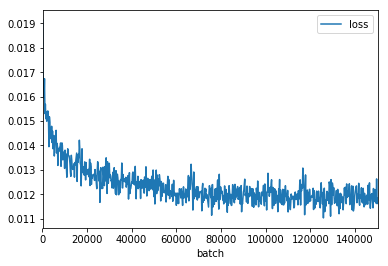

In [36]:
loss_curve.plot.line('batch', 'loss')

## Try Focal Loss

In [37]:
def binary_focal_loss(gamma=2., alpha=.25):
    """
    Binary form of focal loss.
      FL(p_t) = -alpha * (1 - p_t)**gamma * log(p_t)
      where p = sigmoid(x), p_t = p or 1 - p depending on if the label is 1 or 0, respectively.
    References:
        https://arxiv.org/pdf/1708.02002.pdf
    Usage:
     model.compile(loss=[binary_focal_loss(alpha=.25, gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    def binary_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred:  A tensor resulting from a sigmoid
        :return: Output tensor.
        """
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = K.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = K.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = K.clip(pt_0, epsilon, 1. - epsilon)

        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))

    return binary_focal_loss_fixed

## Round 4 with Focal Loss

In [38]:
lr = 1e-4
model_name = 'attn_feat_02_layers-2-stage_04-focal_loss-'

In [39]:
train_n_batches += 50000

In [40]:

# Optimization method
optimizer = Adam(lr=lr)
model.compile(loss=binary_focal_loss(alpha=.25, gamma=2), optimizer=optimizer)
# model.compile(loss='binary_crossentropy', optimizer=optimizer)

DataGenerator = BalGen

train_gen = DataGenerator(
    x=train_x,
    y=train_y,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    verbose=0,
)

train_time = time.time()

for (batch_x, batch_y) in train_gen.generate():

    # Compute stats every several interations
    if i_batch % eval_per_n_batches == eval_per_n_batches-1:

        print("-------------------")

        print(f"Batch: {i_batch}, train time: {time.time() - train_time:.3f} s")

        bal_metrics = evaluate(
            model=model,
            x=train_bal_x,
            target=train_bal_y,
        )
        bal_metrics_list.append(bal_metrics)
        print("Balanced train metrics:")
        print(bal_metrics)
        
        test_metrics = evaluate(
            model=model,
            x=test_x,
            target=test_y,
        )
        test_metrics_list.append(test_metrics)
        print("Test train metrics:")
        print(test_metrics)
        
        print("-------------------\n")
        
        train_time = time.time()

    # Update params
#     (batch_x, batch_y) = transform_data(batch_x, batch_y)
    loss_i = model.train_on_batch(x=batch_x, y=batch_y)
    if i_batch % print_loss_every_n_batches == print_loss_every_n_batches-1:
        loss_curve_list.append({'batch': i_batch, 'loss': loss_i})
        print(f'loss at batch {i_batch}: {loss_i:.6f}')
    
    # Save model
    if i_batch % save_per_n_batches == save_per_n_batches-1:
        save_model_path = model_path/(f'{model_name}after_{i_batch+1:06d}batches.h5')
        model.save(save_model_path)
        
    i_batch += 1

    # Stop training when maximum iteration achieves
    if i_batch >= train_n_batches:
#         model.save(model_path/(f'{model_name}_final.h5'))
        break


loss at batch 150199: 476.854370
loss at batch 150399: 391.560638
loss at batch 150599: 409.104584
loss at batch 150799: 376.542389
loss at batch 150999: 377.830261
loss at batch 151199: 338.652618
loss at batch 151399: 366.698029
loss at batch 151599: 342.246155
loss at batch 151799: 351.518738
loss at batch 151999: 350.821320
loss at batch 152199: 344.926392
loss at batch 152399: 357.094116
loss at batch 152599: 353.672119
loss at batch 152799: 339.548859
loss at batch 152999: 326.321075
loss at batch 153199: 347.509369
loss at batch 153399: 339.756805
loss at batch 153599: 320.749359
loss at batch 153799: 343.478638
loss at batch 153999: 337.853210
loss at batch 154199: 346.861511
loss at batch 154399: 328.485809
loss at batch 154599: 337.675171
loss at batch 154799: 317.925842
-------------------
Batch: 154999, train time: 443.311 s
Balanced train metrics:
{'mAP': 0.5721529672550815, 'mAUC': 0.9874276558858797, 'd_prime': 3.16666825274212}
Test train metrics:
{'mAP': 0.330676093672

## Round 5 with Focal Loss

In [41]:
lr = 1e-5
model_name = 'attn_feat_02_layers-2-stage_05-focal_loss-'

In [42]:
train_n_batches += 50000

In [43]:

# Optimization method
optimizer = Adam(lr=lr)
model.compile(loss=binary_focal_loss(alpha=.25, gamma=2), optimizer=optimizer)
# model.compile(loss='binary_crossentropy', optimizer=optimizer)

DataGenerator = BalGen

train_gen = DataGenerator(
    x=train_x,
    y=train_y,
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    verbose=0,
)

train_time = time.time()

for (batch_x, batch_y) in train_gen.generate():

    # Compute stats every several interations
    if i_batch % eval_per_n_batches == eval_per_n_batches-1:

        print("-------------------")

        print(f"Batch: {i_batch}, train time: {time.time() - train_time:.3f} s")

        bal_metrics = evaluate(
            model=model,
            x=train_bal_x,
            target=train_bal_y,
        )
        bal_metrics_list.append(bal_metrics)
        print("Balanced train metrics:")
        print(bal_metrics)
        
        test_metrics = evaluate(
            model=model,
            x=test_x,
            target=test_y,
        )
        test_metrics_list.append(test_metrics)
        print("Test train metrics:")
        print(test_metrics)
        
        print("-------------------\n")
        
        train_time = time.time()

    # Update params
#     (batch_x, batch_y) = transform_data(batch_x, batch_y)
    loss_i = model.train_on_batch(x=batch_x, y=batch_y)
    if i_batch % print_loss_every_n_batches == print_loss_every_n_batches-1:
        loss_curve_list.append({'batch': i_batch, 'loss': loss_i})
        print(f'loss at batch {i_batch}: {loss_i:.6f}')
    
    # Save model
    if i_batch % save_per_n_batches == save_per_n_batches-1:
        save_model_path = model_path/(f'{model_name}after_{i_batch+1:06d}batches.h5')
        model.save(save_model_path)
        
    i_batch += 1

    # Stop training when maximum iteration achieves
    if i_batch >= train_n_batches:
#         model.save(model_path/(f'{model_name}_final.h5'))
        break


loss at batch 200199: 325.848480
loss at batch 200399: 305.104431
loss at batch 200599: 322.077271
loss at batch 200799: 322.055054
loss at batch 200999: 338.385742
loss at batch 201199: 319.056976
loss at batch 201399: 324.965271
loss at batch 201599: 311.024658
loss at batch 201799: 314.195435
loss at batch 201999: 326.421631
loss at batch 202199: 317.525452
loss at batch 202399: 335.346741
loss at batch 202599: 325.911743
loss at batch 202799: 316.437622
loss at batch 202999: 304.122284
loss at batch 203199: 322.286865
loss at batch 203399: 324.979645
loss at batch 203599: 302.226868
loss at batch 203799: 317.030884
loss at batch 203999: 317.640625
loss at batch 204199: 324.331329
loss at batch 204399: 307.933167
loss at batch 204599: 323.790192
loss at batch 204799: 316.023682
-------------------
Batch: 204999, train time: 443.804 s
Balanced train metrics:
{'mAP': 0.5846475326544633, 'mAUC': 0.9883621264175607, 'd_prime': 3.2086780103199266}
Test train metrics:
{'mAP': 0.3416974967